<h1 style="color:blue;text-align:center">Azure ML Service</h1>

<p style="text-align:center;"><img style="width:80%" src="https://docs.microsoft.com/en-us/samples/microsoft/mlopspython/mlops-with-azure-ml/media/ml-lifecycle.png" /></p>


<h1 style="color:blue;text-align:center"><i>Mallien optimointi</i></h1>

Tässä harjoituksessa kokeillaan mallien optimointia, pyrkimyksenä muodostaa mahdollisimman hyvä ennustemalli
asuntojen hinnalle. Data on haettu Kaggle:sta (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/rules?continue=data#). 

<hr>

## Azure ML työtilan asetus

In [50]:
from azureml.core import Experiment, Workspace, Run
import azureml.core
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Check core SDK version number
print("This notebook was created using SDK version 1.0.62, you are currently running version", 
      azureml.core.VERSION)

This notebook was created using SDK version 1.0.62, you are currently running version 1.0.83


Luetaan konfiguraatio JSON, jonka avulla luodaan yhteys työtilaan:

In [3]:
import json

# read file
with open('../ws_conf.json', 'r') as myfile:
    data = myfile.read()

# parse file
conf = json.loads(data)

conf

{'ws_name': 'MLtraining',
 'subscription_id': '8762927b-0537-46e8-8e47-aa45d83df5f0',
 'resource_group': 'koulutukset'}

**Konfigurointi tiedosto pitää luoda etukäteen**, käyttäen Azure-portaalista löytyviä tietoja.  
Luodaan yhteys `Workspace` funktiolla: 

In [4]:
ws = Workspace(subscription_id = conf['subscription_id'],
               resource_group = conf['resource_group'],
               workspace_name = conf['ws_name'])

In [5]:
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: MLtraining
Azure region: northeurope
Subscription id: 8762927b-0537-46e8-8e47-aa45d83df5f0
Resource group: koulutukset


In [98]:
ws.get_details()

{'id': '/subscriptions/8762927b-0537-46e8-8e47-aa45d83df5f0/resourceGroups/koulutukset/providers/Microsoft.MachineLearningServices/workspaces/MLtraining',
 'name': 'MLtraining',
 'location': 'northeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'sku': 'Basic',
 'workspaceid': 'df07c9c3-7a5c-4431-b438-bb97bfd8ea7a',
 'description': '',
 'friendlyName': '',
 'creationTime': '2019-04-08T11:01:06.3772954+00:00',
 'containerRegistry': '/subscriptions/8762927b-0537-46e8-8e47-aa45d83df5f0/resourcegroups/koulutukset/providers/microsoft.containerregistry/registries/mltraining1068917005',
 'keyVault': '/subscriptions/8762927b-0537-46e8-8e47-aa45d83df5f0/resourcegroups/koulutukset/providers/microsoft.keyvault/vaults/mltraining9221975379',
 'applicationInsights': '/subscriptions/8762927b-0537-46e8-8e47-aa45d83df5f0/resourcegroups/koulutukset/providers/microsoft.insights/components/mltraining4953562360',
 'identityPrincipalId': 'd4b57ea3-8213-4a85-8ae7-d38cdd524173',
 'identityTe

<hr>

## Datan valmistelu

### *Datan kuvaus*

Datassa on 79 selittävää muuttujaa, jotka kuvaavat (lähes) joka aspektin asuinkiinteistöistä. Data on peräisin Amesista, Iowasta. Tavoitteena on ennustaa asuntojen myyntihintaa (`SalesPrice`).

Luetaan data sisään:

In [6]:
import pandas as pd

df = pd.read_csv('house_prices.csv')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### *Data-analyysi*

Näin pienellä aineistolla on selittäjiä pakko karsia ja aloitetaan poistamalla muuttujat joissa on puuttuvia arvoja:

In [87]:
df2 = df.loc[:,df.isna().sum()==0]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 62 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
ExterQual        1460 non-

Yksinkertaisuuden vuoksi keskitytään vain numeerisiin muuttujiin. Aloitetaan laskemalla korrelaatio selittäjien ja vastemuuttujan välille:

In [88]:
cors = df2.corr().round(2).loc['SalePrice'].abs().sort_values()
cors

BsmtFinSF2       0.01
Id               0.02
BsmtHalfBath     0.02
MiscVal          0.02
YrSold           0.03
LowQualFinSF     0.03
3SsnPorch        0.04
MoSold           0.05
OverallCond      0.08
MSSubClass       0.08
PoolArea         0.09
ScreenPorch      0.11
EnclosedPorch    0.13
KitchenAbvGr     0.14
BedroomAbvGr     0.17
BsmtUnfSF        0.21
BsmtFullBath     0.23
LotArea          0.26
HalfBath         0.28
OpenPorchSF      0.32
WoodDeckSF       0.32
2ndFlrSF         0.32
BsmtFinSF1       0.39
Fireplaces       0.47
YearRemodAdd     0.51
YearBuilt        0.52
TotRmsAbvGrd     0.53
FullBath         0.56
1stFlrSF         0.61
TotalBsmtSF      0.61
GarageArea       0.62
GarageCars       0.64
GrLivArea        0.71
OverallQual      0.79
SalePrice        1.00
Name: SalePrice, dtype: float64

In [122]:
# Select features with sufficiently high correlation to the response:
df_num = df2[cors[cors>0.25].index.values]
df_num.columns

Index(['LotArea', 'HalfBath', 'OpenPorchSF', 'WoodDeckSF', '2ndFlrSF',
       'BsmtFinSF1', 'Fireplaces', 'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd',
       'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars',
       'GrLivArea', 'OverallQual', 'SalePrice'],
      dtype='object')

Visualisoidaan vahvimmin korreloivien selittäjien suhdetta vasteeseen:

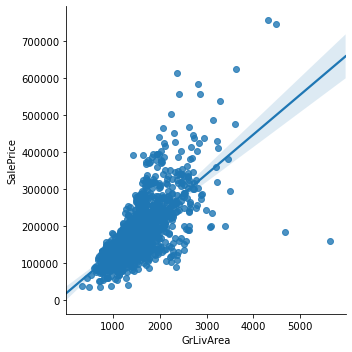

In [90]:
sns.lmplot(x='GrLivArea',y='SalePrice',data = df_num)

Seuraavaksi katsotaan, miltä muuttujien jakaumat näyttävät:

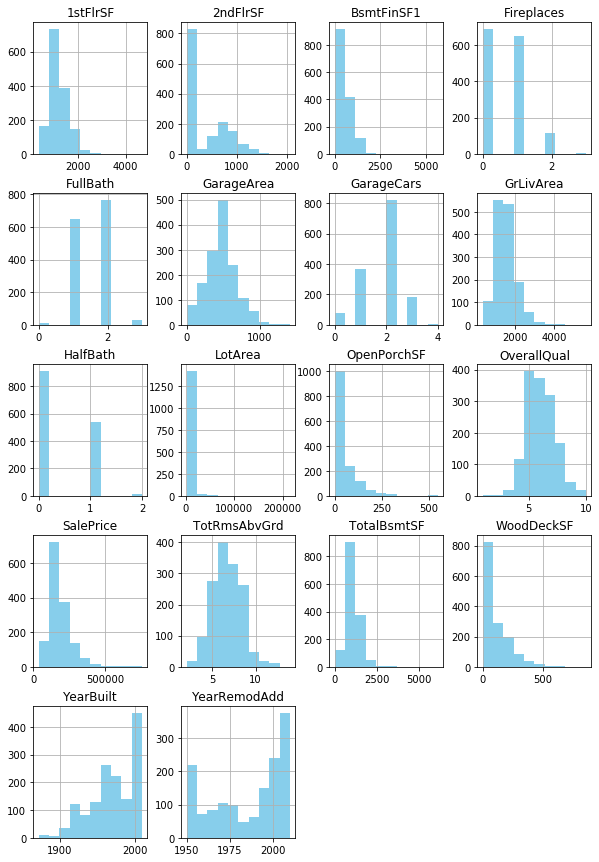

In [91]:
df_num.hist(figsize=(10,15), color='skyblue')
plt.show()

Tehdään joitakin rajauksia dataan:

In [92]:
df_filt = df_num[
    np.logical_and(
        np.logical_and(
            df_num.GrLivArea < 4000,
            df_num.LotArea < 50000
        ),
        df_num.SalePrice < 500000
    ) 
]
df_filt.shape

(1440, 18)

### *Datan jakaminen*

Ennustemallien koulutusta varten data on jaettava opetus- ja testi-setteihin:

In [93]:
from sklearn.model_selection import train_test_split

# Convert to array (required by sklearn):
X = df_filt.drop('SalePrice',axis=1).values
y = df_filt['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print('Sample sizes:')
{k:v['X'].shape[0] for k,v in data.items()}

Sample sizes:


{'train': 1080, 'test': 360}

<hr>

## Mallien koulutus

Ensin luodaan ns. eksperimentti Azure ML työtilaan, johon kaikki tarpeellinen tallennetaan.
Jos nimettyä eksperimenttiä ei ole olemassa, luodaan työtilaan uusi eksperimentti (oletusarvoisesti). Muussa tapauksessa jatketaan olemassa olevaan eksperimenttiin tallentamista. 

In [103]:
# List existing experiments:
ws.experiments

{'experiment_model_int': Experiment(Name: experiment_model_int,
 Workspace: MLtraining),
 'Sample_4_-_Classification__Credit_Ri': Experiment(Name: Sample_4_-_Classification__Credit_Ri,
 Workspace: MLtraining),
 'Experiment_created_on_9_13_2019': Experiment(Name: Experiment_created_on_9_13_2019,
 Workspace: MLtraining),
 'logging-api-test': Experiment(Name: logging-api-test,
 Workspace: MLtraining)}

In [113]:
# Get an experiment object from Azure Machine Learning
experiment = Experiment(workspace = ws, name = "parameter-tuning")

In [105]:
experiment

Name,Workspace,Report Page,Docs Page
parameter-tuning,MLtraining,Link to Azure Machine Learning studio,Link to Documentation


### *Parameteri "pyyhkäisy"*

Seuraavaksi iteroidaan mallin hyperparametreja, löytääksemme optimaalisen mallin. Käytämme tässä esimerkissä *kNN-regressiota* ja tutkimme sen `n_neighbors` parametriä.

In [120]:
# Parameter range for performing a hyperparameter sweep:
k_values = np.arange(3, 13)
k_values

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Ja sitten vaan iteroimaan.  
HUOM: mallin tiedostonimi pysyy vakiona, mutta eksperimenttiin ladataan aina uusi malli kullekin ajokerralle.

In [115]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KNeighborsRegressor
import joblib

# loop through alpha values:
for k in tqdm(k_values):
    
    # create several runs, each train a model with a different alpha value:
    with experiment.start_logging() as run:
        # Fit model:
        model = KNeighborsRegressor(n_neighbors = k,n_jobs = -1)
        model.fit(X = data["train"]["X"], y = data["train"]["y"])
        
        # Evaluate:
        preds = model.predict(X = data["test"]["X"])
        metric = mse(y_true = data["test"]["y"], y_pred = preds)

        # log alpha, mean_squared_error and feature names in run history
        run.log(name = "n_neighbors", value = k)
        run.log(name = "mse", value = metric)
        
        # Save the model to the outputs directory for capture
        joblib.dump(value = model, filename = 'outputs/model.pkl')
        
        # log model:
        run.upload_file('model.pkl', 'outputs/model.pkl')

100%|██████████| 13/13 [01:02<00:00,  4.79s/it]


In [116]:
experiment

Name,Workspace,Report Page,Docs Page
parameter-tuning,MLtraining,Link to Azure Machine Learning studio,Link to Documentation


### *Parhaan mallin valinta*

Lopuksi valikoidaan opetetuista malleista paras, eli se jonka tuottamissa ennusteissa oli vähiten virhettä.

In [117]:
runs = {}
run_metrics = {}

# Create dictionaries containing the runs and the metrics for all runs containing the 'mse' metric
for r in tqdm(experiment.get_runs()):
    
    metrics = r.get_metrics()
    
    if 'mse' in metrics.keys():
        runs[r.id] = r
        run_metrics[r.id] = metrics

13it [00:04,  3.07it/s]


Visualisoidaan mallien virhe:

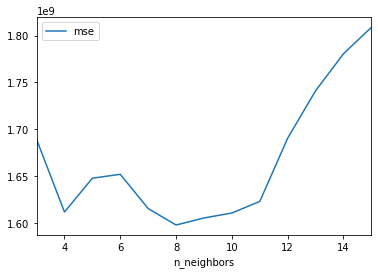

In [118]:
pd.DataFrame.from_dict(run_metrics,orient='index').plot(x='n_neighbors',y='mse')

Ja lopuksi tägätään paras malli:

In [119]:
# Find the run with the best (lowest) mean squared error and display the id and metrics
best_run_id = min(run_metrics, key = lambda k: run_metrics[k]['mse'])
best_run = runs[best_run_id]

print('Best run is:', best_run_id)
print('Metrics:', run_metrics[best_run_id])

# Tag the best run for identification later
best_run.tag("Best Run")

Best run is: 69031ea3-f863-4a8c-a858-5fda7f3c2e2c
Metrics: {'n_neighbors': 8, 'mse': 1597878475.5623264}


Käy katsomassa mikä on muuttunut:

In [121]:
experiment

Name,Workspace,Report Page,Docs Page
parameter-tuning,MLtraining,Link to Azure Machine Learning studio,Link to Documentation
